# Inference: Metropolis Random Walk MCMC

This example shows you how to perform Bayesian inference on a time series, using [Metropolis Random Walk MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/metropolis_mcmc.html).

It follows on from the [first sampling example](./first-example.ipynb).

Running...
Done!
param        mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-----------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
growth rate  0.02    0.00    0.02    0.02    0.02    0.02    0.02     1.01    206.49  16.09
capacity     500.47  0.45    499.60  500.15  500.49  500.77  501.25   1.05    75.72   5.90


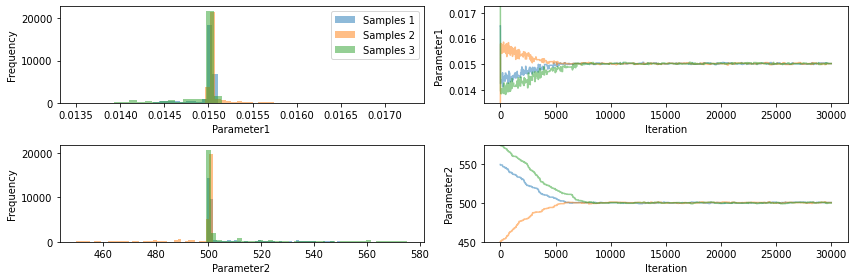

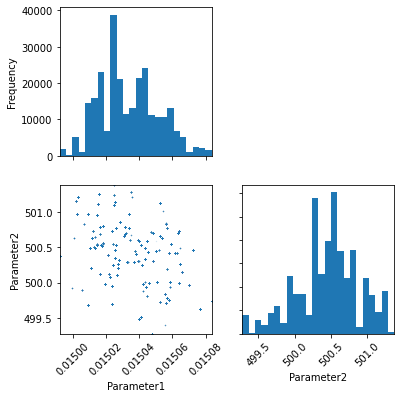

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Choose a covariance matrix for the proposal step
sigma0 = np.abs(real_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 10000:, :]

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['growth rate', 'capacity'])
print(results)

# Look at distribution in chain 0
pints.plot.pairwise(chains[0])

# Show graphs
plt.show()